# Import Libraries

## reference
[Monet_To_Photo_CycleGAN.ipynb](https://github.com/VishalVasoya1/Cycle-GAN-Recreate-Masterpiece/blob/main/CycleGAN%20Training/Monet_To_Photo_CycleGAN.ipynb)

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from tensorflow_addons.layers import InstanceNormalization
from matplotlib import pyplot

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from numpy import asarray
from numpy import vstack
from keras.utils import img_to_array
from keras.utils import load_img
from matplotlib import pyplot as plt

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/'
# trainA_dir = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/trainA'
# trainB_dir = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/trainB'
# testA_dir = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/testA'
# testB_dir = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/testB'

In [ ]:
# trainA = os.listdir(trainA_dir)
# print("Monet Training Files: ", len(trainA))

# trainB = os.listdir(trainB_dir)
# print("Real Image Training Files: ", len(trainB))

# testA = os.listdir(testA_dir)
# print("Monet testing Files: ", len(testA))

# testB = os.listdir(testB_dir)
# print("Real Image testing Files: ", len(testB))

In [ ]:
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in os.listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)
# print(type(dataA_all))

from sklearn.utils import resample

#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all,
                 replace=False,
                 n_samples=5,
                 random_state=42)
# print(dataA)

Loaded dataA:  (20, 256, 256, 3)


In [ ]:
# load dataset B - Photos
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataB = resample(dataB_all,
                 replace=False,
                 n_samples=5,
                 random_state=42)

Loaded dataB:  (20, 256, 256, 3)


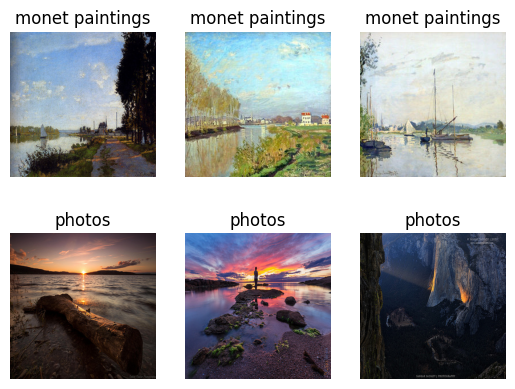

In [ ]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
	plt.title('monet paintings')
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
	plt.title('photos')
plt.show()

In [ ]:
# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

Loaded (5, 256, 256, 3) (5, 256, 256, 3)


In [ ]:
#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	# print('X1', X1)
	# print('X2', X2)
	return [X1, X2]

dataset = preprocess_data(data)

# Define Discriminator

In [ ]:
def define_discriminator(image_shape):
  init = RandomNormal(stddev = 0.02)
  print(init)
  in_image = Input(shape=image_shape)
  # 4 x 4 kernel
  d = Conv2D(64, (4,4), strides = (2,2), padding = 'same', kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  model = Model(in_image, patch_out)
  model.compile(loss = "mse", optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
  print("image shape from dis ", d.shape)
  return model

# Define ResNet Block

In [ ]:
def resnet_block(n_filters, input_layer):
  init = RandomNormal(stddev = 0.02)

  # first convoluntional layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  print("instancenormalization g ", g)
  g = Activation('relu')(g)

  # second convoluntional layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)

  g = Concatenate()([g, input_layer])
  return g


# Define Generator

In [ ]:
def define_generator(image_shape, n_resnet=9):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    g = Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    for _ in range(n_resnet):
        g = resnet_block(256, g)

    g = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    print("image shape form g model", out_image.shape)
    return model


# Define composite model



Adverserial Loss

	-> generator_photo_to_monet(photo) -> monet -> discriminator(monet) -> real/fake


Identity Loss

	-> generator_photo_to_monet(monet) -> monet -> check both input and generated output is identical or not


Forward Loss

	-> generator_photo_to_monet(photo) -> monet -> generator_monet_to_photo(generated_monete) -> photo


Backward Loss

	-> generator_monet_to_photo(monet) -> photo -> generator_photo_to_monet(generated_photo) -> monet


In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):

    g_model_1.trainable = True
    # mark discriminator and second generator as non-trainable
    d_model.trainable = False
    g_model_2.trainable = False

    # adversarial loss
    print('adversarial loss ',image_shape)
    input_gen = Input(shape=image_shape)
    print('adversarial loss input_gen ',input_gen)
    gen1_out = g_model_1(input_gen)
    print('adversarial loss gen1_out ',gen1_out)
    output_d = d_model(gen1_out)
    print('adversarial loss output_d ',output_d)
    # identity loss
    print("identity loss",image_shape)
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle loss - forward
    output_f = g_model_2(gen1_out)
    # cycle loss - backward
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)

    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
      # define the optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'],
                loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

# Define Helper Function

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1.
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_%06d.h5' % (step+1)
	print(filename1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '/content/drive/MyDrive/Colab Notebooks/monet_paintings/Performance/%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# Train Cycle Gan

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset trainA : monet, trainB : photos
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 1) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
image_shape = dataset[0].shape[1:]
print(image_shape)

(256, 256, 3)


In [ ]:
# image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
print("g_model_AtoB", g_model_AtoB)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
print("g_model_BtoA", g_model_BtoA)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


instancenormalization g  KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='instance_normalization_3/batchnorm/add_1:0', description="created by layer 'instance_normalization_3'")
instancenormalization g  KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='instance_normalization_5/batchnorm/add_1:0', description="created by layer 'instance_normalization_5'")
instancenormalization g  KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='instance_normalization_7/batchnorm/add_1:0', description="created by layer 'instance_normalization_7'")
instancenormalization g  KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='instance_normalization_9/batchnorm/add_1:0', description="created by layer 'instance_normalization_9'")
instancenormalization g  KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float3

In [ ]:
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
print("d_model_A", d_model_A)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
print("d_model_B", d_model_B)

image shape from dis  (None, 16, 16, 512)
d_model_A <keras.engine.functional.Functional object at 0x7998104990c0>
image shape from dis  (None, 16, 16, 512)
d_model_B <keras.engine.functional.Functional object at 0x799810401540>


In [ ]:
# print(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

adversarial loss  (256, 256, 3)
adversarial loss input_gen  KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
adversarial loss gen1_out  KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='model/activation_13/Tanh:0', description="created by layer 'model'")
adversarial loss output_d  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1), dtype=tf.float32, name=None), name='model_3/conv2d_51/BiasAdd:0', description="created by layer 'model_3'")
identity loss (256, 256, 3)
adversarial loss  (256, 256, 3)
adversarial loss input_gen  KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")
adversarial loss gen1_out  KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='model_1/activation_27/Tanh:0', descrip

In [ ]:
from datetime import datetime
start1 = datetime.now()
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=6)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 8s 8s/step
Iteration>1, dA[0.803,0.872] dB[1.705,0.817] g[20.319,18.589]
1/1 [==============================] - 7s 7s/step
Iteration>2, dA[8.086,1.348] dB[5.848,2.431] g[20.607,20.186]
1/1 [==============================] - 5s 5s/step
Iteration>3, dA[5.186,3.899] dB[16.916,6.392] g[18.575,21.119]
1/1 [==============================] - 6s 6s/step
Iteration>4, dA[3.166,4.921] dB[2.401,2.046] g[16.435,22.667]
1/1 [==============================] - 5s 5s/step
Iteration>5, dA[0.673,3.112] dB[1.197,0.555] g[15.550,17.125]
1/1 [==============================] - 29s 29s/step


/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000005.h5


>Saved: /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000005.h5 and /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_000005.h5
1/1 [==============================] - 6s 6s/step
Iteration>6, dA[1.785,1.349] dB[0.947,0.939] g[17.228,18.229]
1/1 [==============================] - 7s 7s/step
Iteration>7, dA[0.877,0.580] dB[0.543,2.100] g[16.173,16.875]
1/1 [==============================] - 5s 5s/step
Iteration>8, dA[0.548,0.850] dB[0.572,1.268] g[15.953,14.946]
1/1 [==============================] - 7s 7s/step
Iteration>9, dA[0.647,0.921] dB[0.415,0.709] g[14.218,15.678]
1/1 [==============================] - 7s 7s/step
Iteration>10, dA[0.298,0.468] dB[0.267,0.402] g[13.014,14.168]
1/1 [==============================] - 29s 29s/step


/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000010.h5


>Saved: /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000010.h5 and /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_000010.h5
1/1 [==============================] - 7s 7s/step
Iteration>11, dA[0.367,0.558] dB[0.349,0.359] g[10.332,11.610]
1/1 [==============================] - 5s 5s/step
Iteration>12, dA[0.363,0.354] dB[0.233,0.366] g[9.540,10.250]
1/1 [==============================] - 7s 7s/step
Iteration>13, dA[0.217,0.211] dB[0.193,0.421] g[10.889,12.006]
1/1 [==============================] - 7s 7s/step
Iteration>14, dA[0.284,0.647] dB[0.272,0.271] g[13.509,13.203]
1/1 [==============================] - 7s 7s/step
Iteration>15, dA[0.198,0.575] dB[0.280,0.173] g[9.963,10.625]
1/1 [==============================] - 29s 29s/step


/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000015.h5


>Saved: /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000015.h5 and /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_000015.h5
1/1 [==============================] - 8s 8s/step
Iteration>16, dA[0.500,0.384] dB[0.307,0.283] g[11.565,12.891]
1/1 [==============================] - 5s 5s/step
Iteration>17, dA[0.285,0.256] dB[0.221,0.197] g[9.178,9.751]
1/1 [==============================] - 5s 5s/step
Iteration>18, dA[0.503,0.353] dB[0.153,0.261] g[12.178,11.605]
1/1 [==============================] - 5s 5s/step
Iteration>19, dA[0.225,0.576] dB[0.184,0.208] g[8.222,9.220]
1/1 [==============================] - 5s 5s/step
Iteration>20, dA[0.145,0.506] dB[0.158,0.194] g[9.444,11.190]
1/1 [==============================] - 29s 29s/step


/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000020.h5


>Saved: /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000020.h5 and /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_000020.h5
1/1 [==============================] - 7s 7s/step
Iteration>21, dA[0.373,0.501] dB[0.221,0.150] g[9.154,9.994]
1/1 [==============================] - 5s 5s/step
Iteration>22, dA[0.183,0.513] dB[0.319,0.221] g[9.541,9.939]
1/1 [==============================] - 6s 6s/step
Iteration>23, dA[0.117,0.343] dB[0.125,0.177] g[13.669,13.583]
1/1 [==============================] - 5s 5s/step
Iteration>24, dA[0.126,0.214] dB[0.154,0.129] g[10.469,11.328]
1/1 [==============================] - 6s 6s/step
Iteration>25, dA[0.254,0.293] dB[0.165,0.161] g[8.783,9.523]
1/1 [==============================] - 29s 29s/step


/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000025.h5


>Saved: /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000025.h5 and /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_000025.h5
1/1 [==============================] - 6s 6s/step
Iteration>26, dA[0.306,0.220] dB[0.136,0.137] g[8.552,8.677]
1/1 [==============================] - 5s 5s/step
Iteration>27, dA[0.124,0.337] dB[0.233,0.213] g[9.179,9.419]
1/1 [==============================] - 5s 5s/step
Iteration>28, dA[0.269,0.233] dB[0.110,0.146] g[8.295,8.303]
1/1 [==============================] - 5s 5s/step
Iteration>29, dA[0.129,0.250] dB[0.111,0.155] g[11.577,10.506]
1/1 [==============================] - 5s 5s/step
Iteration>30, dA[0.089,0.186] dB[0.213,0.207] g[9.197,10.773]
1/1 [==============================] - 29s 29s/step


/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000030.h5


>Saved: /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000030.h5 and /content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_000030.h5
Execution time is:  1:52:35.169523


# Test Trainded Model

In [ ]:
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint
import numpy as np

In [ ]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [ ]:
# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i],fontsize=15, color= 'white', fontweight='bold')
	pyplot.show()

In [ ]:
# load dataset
A_data = resample(dataA_all,
                 replace=False,
                 n_samples=5,
                 random_state=42) # reproducible results

B_data = resample(dataB_all,
                 replace=False,
                 n_samples=5,
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [ ]:
# print(A_data)

In [ ]:
# load the models
model_monet_to_photo = load_model('/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_AtoB_000030.h5')
model_photo_to_monet = load_model('/content/drive/MyDrive/Colab Notebooks/monet_paintings/Models/g_model_BtoA_000030.h5')

(1, 256, 256, 3)
1/1 [==============================] - 5s 5s/step


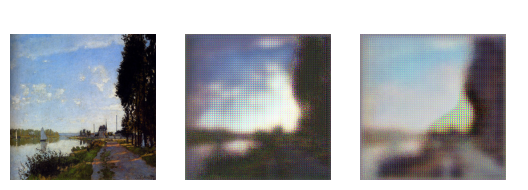

In [ ]:
# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
print(A_real.shape)
B_generated  = g_model_AtoB.predict(A_real)
A_reconstructed = g_model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

In [ ]:
#Load a single custom image
size = (256,256)
test_image = load_img('/content/drive/MyDrive/Colab Notebooks/monet_paintings/trainB/2013-11-08 16_45_24.jpg', target_size=size)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

In [ ]:
# print(test_image)

In [ ]:
# print(test_image_input)

1/1 [==============================] - 6s 6s/step


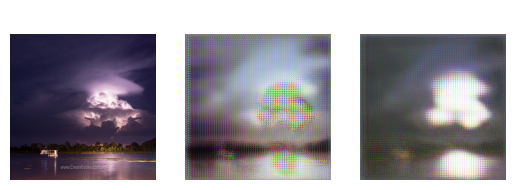

In [ ]:
# plot B->A->B (Photo to Monet to Photo)
monet_generated  = g_model_BtoA.predict(test_image_input)
photo_reconstructed = g_model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)

In [ ]:
#Load a single custom image
size = (256,256)
test_image = load_img('/content/drive/MyDrive/Colab Notebooks/monet_paintings/trainB/2013-11-10 06_42_01.jpg', target_size=size)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

1/1 [==============================] - 6s 6s/step


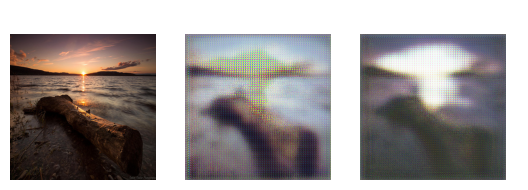

In [ ]:
# plot B->A->B (Photo to Monet to Photo)
monet_generated  = g_model_BtoA.predict(test_image_input)
photo_reconstructed = g_model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)

In [ ]:
g_model_BtoA.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization_23 (Ins  (None, 256, 256, 64  128        ['conv2d_21[0][0]']              
 tanceNormalization)            )                                                           

In [ ]:
g_model_AtoB.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization (Instan  (None, 256, 256, 64  128        ['conv2d[0][0]']                 
 ceNormalization)               )                                                             